In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [2]:
data = pd.read_csv("stocks.csv")

In [3]:
data.head()

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,AAPL,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
1,AAPL,2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100
2,AAPL,2023-02-09,153.779999,154.330002,150.419998,150.869995,150.639999,56007100
3,AAPL,2023-02-10,149.460007,151.339996,149.220001,151.009995,151.009995,57450700
4,AAPL,2023-02-13,150.949997,154.259995,150.919998,153.850006,153.850006,62199000


In [4]:
data.shape

(248, 8)

In [5]:
data.columns

Index(['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close',
       'Volume'],
      dtype='object')

In [ ]:
pd.isnull(data).sum()

### # Select relevant columns

In [6]:
# Select relevant columns
selected_columns = ['Open', 'High', 'Low', 'Volume', 'Close']
data = data[selected_columns]


In [7]:
# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)


In [8]:
# Define the number of previous days' data to consider for prediction
seq_length = 10

# Create sequences for input and output
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length, -1])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, seq_length)


In [9]:
# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


### Build the LSTM model

In [10]:
# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 4)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/50
12/12 [==============================] - 4s 59ms/step - loss: 0.1506 - val_loss: 0.0065
Epoch 2/50
12/12 [==============================] - 0s 14ms/step - loss: 0.0262 - val_loss: 0.0129
Epoch 3/50
12/12 [==============================] - 0s 13ms/step - loss: 0.0166 - val_loss: 0.0038
Epoch 4/50
12/12 [==============================] - 0s 13ms/step - loss: 0.0133 - val_loss: 0.0020
Epoch 5/50
12/12 [==============================] - 0s 13ms/step - loss: 0.0112 - val_loss: 4.6663e-04
Epoch 6/50
12/12 [==============================] - 0s 13ms/step - loss: 0.0102 - val_loss: 1.4533e-04
Epoch 7/50
12/12 [==============================] - 0s 13ms/step - loss: 0.0096 - val_loss: 9.2927e-05
Epoch 8/50
12/12 [==============================] - 0s 12ms/step - loss: 0.0088 - val_loss: 7.4180e-05
Epoch 9/50
12/12 [==============================] - 0s 14ms/step - loss: 0.0085 - val_loss: 1.6133e-04
Epoch 10/50
12/12 [==============================] - 0s 16ms/step - loss: 0.0079 - val_lo

In [12]:
# Make predictions
test_predictions = model.predict(X_test)
test_predictions_unscaled = np.concatenate((X_test[:, -1, :], test_predictions), axis=1)
test_predictions_unscaled = scaler.inverse_transform(test_predictions_unscaled)
predicted_prices = test_predictions_unscaled[:, -1]



2/2 [==============================] - 0s 6ms/step


In [13]:
# Calculate RMSE
rmse = math.sqrt(mean_squared_error(y_test, test_predictions))
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 0.01389989652752631


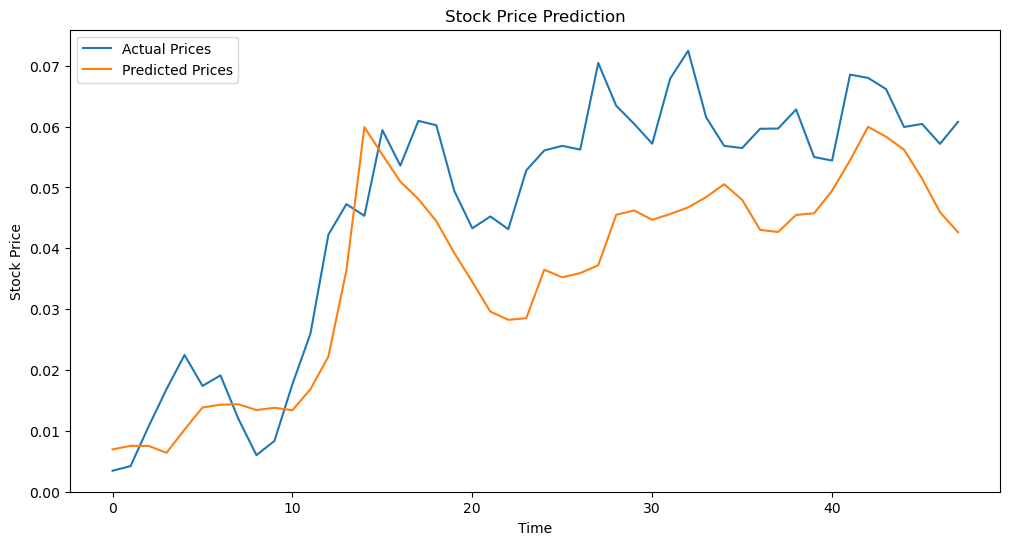

In [14]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Prices')
plt.plot(test_predictions, label='Predicted Prices')
plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()